In [17]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import sklearn


#reading in the "salaries" and "batters" dataframe
salaries = pd.read_csv('Salaries.csv')
batters = pd.read_csv('Batting.csv.zip')

#combining "salaries" and "batters" into a dataframe with all desired variables
batters = batters.merge(salaries, how='inner', on=['playerID', 'yearID'])

#Getting rid of batters who had 70 or less at bats, for more reliable data
batters = batters.loc[batters['AB'] > 70]

#calculates plate appearances and sets that to 'AB' column
batters['AB'] = batters['AB'] + batters['BB'] + batters['HBP']

#converting numeric stats into rates, by dividing by the number of at bats
rates = ['R', 'H', '2B', '3B', 'HR', 'RBI', 'SB', 'CS', 'BB', 'SO', 'IBB', 'GIDP']
for stat in rates:
    batters[stat] = batters[stat]/batters['AB']
    batters.rename(columns={stat: stat + '/PA'}, inplace = True)

#getting rid of redundant/ un-informational variables
batters = batters.drop(['playerID', 'stint', 'teamID_y', 'lgID_y', 'HBP', 'SH', 'SF', 'G', 'AB'], axis=1)

#cleaning up some names
batters.rename(columns={'teamID_x': 'teamID'}, inplace = True)
batters.rename(columns={'lgID_x': 'lgID'}, inplace = True)

#printing the columns of our current dataframe
print(batters.columns)



Index(['yearID', 'teamID', 'lgID', 'R/PA', 'H/PA', '2B/PA', '3B/PA', 'HR/PA',
       'RBI/PA', 'SB/PA', 'CS/PA', 'BB/PA', 'SO/PA', 'IBB/PA', 'GIDP/PA',
       'salary'],
      dtype='object')


In [18]:
from collections import defaultdict
from itertools import count

#a function which converts a list of strings into a list of corresponding numbers accounting for duplicates,
#ie ['this', 'is', 'a', 'test', 'this', 'test', 'has', 'duplicates', 'test'] goes to [1, 2, 3, 4, 1, 4, 5, 6, 4]
#it returns the resulting list of numbers and a dictionary mapping the strings to their corresponding number (ie. 'test': 4)

def make_numeric(alist):
    copy = []
    index = 1
    word_to_index = {}
    for word in alist:
        if word in word_to_index:
            continue
        word_to_index[word] = index
        index += 1
    for i in range(len(alist)):
        copy.append(word_to_index[alist[i]])
    return [copy, word_to_index]

In [19]:
#converts the 'teamID' column of our data frame to a list of integers, each corresponding to a different team
#also saves a dictionary called "team_names" mapping the integers to their respective team names.  Will be used later. 
batters['teamID'], team_names = make_numeric(np.asarray(batters['teamID']))

#turns our leage id column into a a bionary numberic column, 1 in NL and 0 if AL
batters['lgID'] = (batters['lgID'] == 'NL').astype(int)


print(team_names)


{'PHI': 1, 'PIT': 2, 'SLN': 3, 'BOS': 4, 'HOU': 5, 'CLE': 6, 'NYN': 7, 'LAN': 8, 'CHA': 9, 'OAK': 10, 'KCA': 11, 'TEX': 12, 'TOR': 13, 'NYA': 14, 'CIN': 15, 'ATL': 16, 'CAL': 17, 'DET': 18, 'SDN': 19, 'SEA': 20, 'CHN': 21, 'SFN': 22, 'MON': 23, 'MIN': 24, 'ML4': 25, 'BAL': 26, 'FLO': 27, 'COL': 28, 'ANA': 29, 'ARI': 30, 'TBA': 31, 'MIL': 32, 'LAA': 33, 'WAS': 34, 'MIA': 35}


In [20]:
import math

#creates a training set and test set for our data.  It takes 80% of the rows of our dataframe for the training set,
#and the other %20 is used for testing

#finds number n that is 80% of the size of our test set
trainnum = math.floor(batters.shape[0]*.8)

#creates array of integers which are randomly choosen 80% of the numbers between 1 and n
train_ids = np.random.choice(batters.shape[0], replace=False, size=trainnum) 

#sets test_ids to be an array of the remaining 20% of integers
train_ids_set = set(train_ids) 
full_set = set(range(batters.shape[0])) 
test_ids_set = full_set - train_ids_set 
test_ids = list(test_ids_set)

#creates dataframes with the corresponding indices, so that train_batters and test_batters have 80% and 20% of the
#data respectively
train_batters = batters.iloc[train_ids]
test_batters = batters.iloc[test_ids]

#creates appropriate train and tests
x_train = train_batters.drop('salary', axis=1)
y_train = train_batters['salary']
x_test = test_batters.drop('salary', axis=1)
y_test = test_batters['salary']


In [21]:
from sklearn import tree

#builds and trains decision tree model
tree_model = tree.DecisionTreeClassifier(criterion='entropy')
my_tree_model  = tree_model.fit(x_train, y_train)

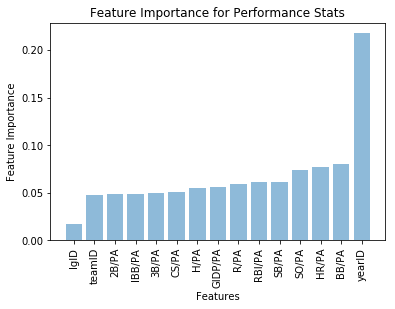

In [22]:
#creates an array with the variables respective importances
importances = my_tree_model.feature_importances_

#makes a bar graph of the sorted feater importances
objects = train_batters.drop('salary', axis=1).columns
temp = pd.DataFrame({'col1':importances, 'col2':objects})
temp = temp.sort_values(by=['col1'])
importances = np.asarray(temp['col1'])
objects = np.asarray(temp['col2'])

y_pos = np.arange(len(objects))
 
plt.bar(y_pos, importances, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.xlabel('Features')
plt.ylabel('Feature Importance')
plt.title('Feature Importance for Performance Stats')
plt.xticks(rotation=90)
 
plt.show()

In [23]:
#unsurprisingly, yearID is by far the most predictive variable (interestingly followed by strike out rate).  To account
#for this, I changed the salary column.  For each data point, if the players salary was in the top quartile for that
#year, I made it a 1.  If not, it was a zero.  Basically only players who were in the 25% top payed players received a
#1.  Everyone else received a zero.  The following is the code for that.

#makes a list of years between 1985 and 2016
years = []
year = 1985
while (year <= 2016):
    years.append(year)
    year +=1

#creates an array avg_sal of salaries where each entry is the average salary for the corresponding year
#also creates a dictionary where the keys are years and the values is the corresponding cut-off for the top quartile
#of salaries for that year
avg_sal = []
top_sal = {}
for num in years:
    temp = batters.loc[batters['yearID'] == num]
    avg_sal.append(temp['salary'].mean())
    top_sal[num] = [temp['salary'].quantile(.75)]
    

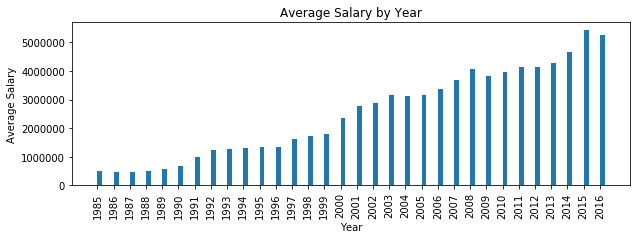

In [24]:
#for fun, the is a graph of average salary by year
x_pos = np.arange(len(years))

plt.figure(figsize=(10, 3))
    
plt.bar(x_pos, avg_sal, align='edge', width=0.3)
plt.xticks(x_pos, years)
plt.ylabel('Average Salary')
plt.xlabel('Year')
plt.title('Average Salary by Year')
plt.xticks(rotation=90)
 
plt.show()

In [25]:
#rescaling indexes of our data frame so that it is indexed in the expected way (ie 1, 2, 3...)
batters.index = np.arange(0, len(batters))

#initiates an array that will later replace the 'salary' column of the array as desired
new_col = [None] * len(batters)

#itterates through the years 1985 to 2016.  For each year, it assigns 1s and 0s to players according to whether their
#salaries were in the top quartile for the given year
for num in years:
    year_indices = batters.index[batters['yearID'] == num]
    for i in year_indices:
        sal = batters.iloc[i]['salary']
        if (sal >= top_sal[num]):
            new_col[i] = 1
        else:
            new_col[i] = 0

#sets 'salary' to our newly calculated column
batters['salary'] = new_col

In [26]:
#initiates an array that will have average salaries per team, controled for by year, by our top quartile method
team_sals = []
#initiates an array that will have the corresponding team name abreviations, for graphing purposes
t_names = []

#inverts our name: integer dictionary from before to make it easier to use
inv_team_names = {v: k for k, v in team_names.items()}

#fills out team_sals and team_names respectively
for i in range(len(inv_team_names)):
    temp = batters.loc[(batters['teamID'] == (i + 1))]
    team_sals.append(temp['salary'].mean())
    t_names.append(inv_team_names[i+1])

#gets data ready for graphing by storing salaries and team names in a dataframe and then sorting the dataframe
#with respect to salaries.
sorting = pd.DataFrame({'names': t_names, 'salaries': team_sals})
sorting = sorting.sort_values(by='salaries')

t_names = sorting['names']
team_sals = sorting['salaries']
    
x_pos = np.arange(len(t_names))

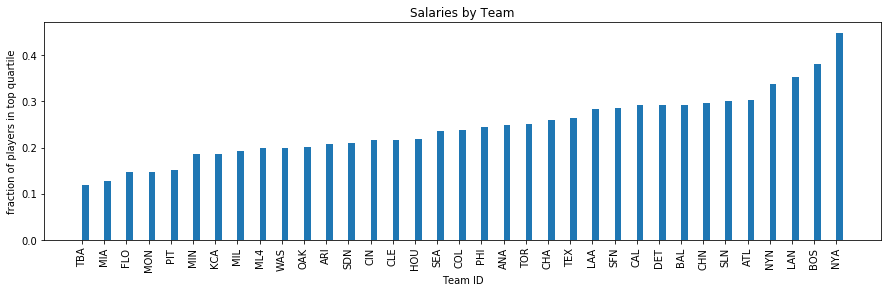

In [27]:
#For fun this is a graph of fraction of players in the top quartile by team.  Results are not suprising, the 
#highest salaried teams are the Yankees, Red Sox, Dodgers, Mets, and Braves.
plt.figure(figsize=(15, 4)) 
    
plt.bar(x_pos, team_sals, align='edge', width=0.3)
plt.xticks(x_pos, t_names)
plt.ylabel('fraction of players in top quartile')
plt.xlabel('Team ID')
plt.title('Salaries by Team')
plt.xticks(rotation=90)

plt.show()

In [28]:
print(batters.columns)

batters = batters.drop(['yearID', 'teamID', 'lgID'],axis=1)

train_batters = batters.iloc[train_ids]
test_batters = batters.iloc[test_ids]

#creates appropriate train and tests
x_train = train_batters.drop('salary', axis=1)
y_train = train_batters['salary']
x_test = test_batters.drop('salary', axis=1)
y_test = test_batters['salary']

Index(['yearID', 'teamID', 'lgID', 'R/PA', 'H/PA', '2B/PA', '3B/PA', 'HR/PA',
       'RBI/PA', 'SB/PA', 'CS/PA', 'BB/PA', 'SO/PA', 'IBB/PA', 'GIDP/PA',
       'salary'],
      dtype='object')


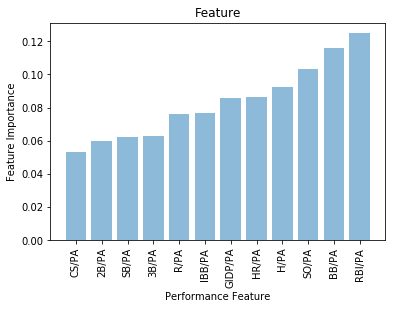

In [29]:
#redoing our feature importance graph with new salary column

#builds and trains decision tree model
tree_model = tree.DecisionTreeClassifier(criterion='entropy')
my_tree_model  = tree_model.fit(x_train, y_train)

#creates an array with the variables respective importances
importances = my_tree_model.feature_importances_

#makes a bar graph of the sorted feater importances
objects = train_batters.drop('salary', axis=1).columns
temp = pd.DataFrame({'col1':importances, 'col2':objects})
temp = temp.sort_values(by=['col1'])
importances = np.asarray(temp['col1'])
objects = np.asarray(temp['col2'])

y_pos = np.arange(len(objects))
 
plt.bar(y_pos, importances, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.ylabel('Feature Importance')
plt.xlabel('Performance Feature')
plt.title('Feature')
plt.xticks(rotation=90)
 
plt.show()

In [30]:
from sklearn import preprocessing


#Rescaling all features in order to prefore logistic regression and support vector machines
for column_name in batters:
    if column_name != 'salary':
        batters[column_name] = preprocessing.scale(batters[column_name])


In [31]:
import scipy
from sklearn.datasets import load_iris
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import roc_curve, auc
from sklearn import metrics
import statistics

#First I want to bootstrap my model to find the optimal samplesize, and whether I should use a logistic regression
#model or a Support Vectors Machines model.
#function which takes in a training dataframe (train), a testing dataframe(test), a number of iteration (nruns), an
#indicator "lr" that's "1" for logistic regression and "0" for Support Vector Machines, and a target variable (label).
#It returns as a list with length 2 the average auc value and the average standard deviation.
def modBootstrapper(train, test, nruns, sampsize, lr, label):
    auc_tracker = []
    for i in range(nruns):
        #creates random sample and respective training sets
        sample = np.random.choice(train.shape[0], replace=True, size=sampsize)
        train_sample = train.iloc[sample]
        x_train = train_sample.drop(label, axis=1)
        y_train = train_sample[label]
        #trains model according to lr
        if (lr == 1):
            model_logistic = sklearn.linear_model.LogisticRegression(C=1e30)
            mymodel = model_logistic.fit(x_train, y_train)
        else:
            model_SVM = sklearn.svm.SVC(kernel="linear", probability=True)
            mymodel = model_SVM.fit(x_train, y_train)
        
        #finds auc and appends it to aucs
        x_test = test.drop(label, axis=1)
        y_test = test[label]
        y_scores = mymodel.predict_proba(x_test)[:,1]
        fpr, tpr, threshold = metrics.roc_curve(y_test, y_scores)
        auc_tracker.append(auc(fpr, tpr))
    
    aucs = [statistics.mean(auc_tracker), math.sqrt(np.var(auc_tracker)/len(auc_tracker))]
    return aucs

#creates train and test sets again
trainnum = math.floor(batters.shape[0]*.8)
train_ids = np.random.choice(batters.shape[0], replace=False, size=trainnum) 
train_ids_set = set(train_ids) 
full_set = set(range(batters.shape[0])) 
test_ids_set = full_set - train_ids_set 
test_ids = list(test_ids_set)


train_batters = batters.iloc[train_ids]
test_batters = batters.iloc[test_ids]


In [32]:
#creates a list of posible sample sizes
samplesizes = [150, 375, 750, 1500, 3000, 6000, 10000]
#initializing arrays we will use later to graph the proformance of logistic regression versus SVM
mean_logistic = []
mean_svm = []
sd_logistic = []
sd_svm = []
#finds the mean and sd corresponding to each samplesize and model
for samp in samplesizes:
    #performs both a logistic regression and SVM model for each samplesize
    mean_log, sd_log = modBootstrapper(train_batters, test_batters, 20, samp, 1, 'salary')
    svm_mean, svm_sd = modBootstrapper(train_batters, test_batters, 20, samp, 0, 'salary')
    #appends to desired lists
    mean_logistic.append(mean_log)
    mean_svm.append(svm_mean)
    sd_logistic.append(sd_log)
    sd_svm.append(svm_sd)


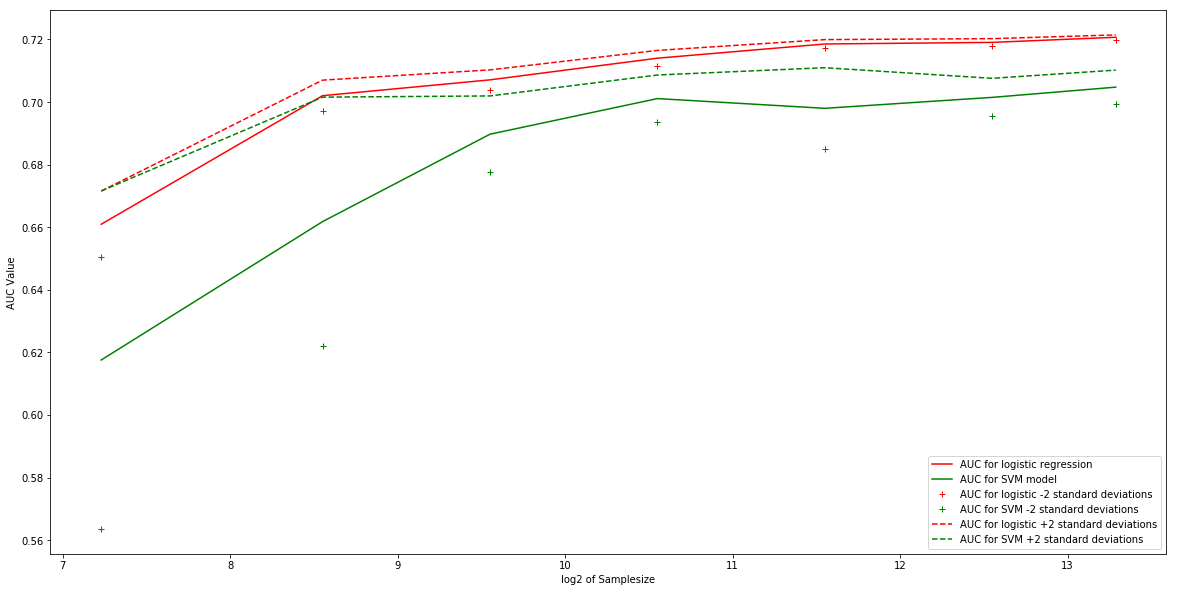

In [33]:
#creates x axis
log_samplesizes = np.log2(samplesizes)

#creates output values
neg_stderr_logistic = np.asarray(mean_logistic) - 2*np.asarray(sd_logistic)
neg_stderr_svm = np.asarray(mean_svm) - 2*np.asarray(sd_svm)
pos_stderr_logistic = np.asarray(mean_logistic) + 2*np.asarray(sd_logistic)
pos_stderr_svm = np.asarray(mean_svm) + 2*np.asarray(sd_svm)

#graph
plt.figure(figsize=(20,10))

plt.plot(log_samplesizes, mean_logistic, 'r', label='AUC for logistic regression')
plt.plot(log_samplesizes, mean_svm, 'g', label='AUC for SVM model')
plt.plot(log_samplesizes, neg_stderr_logistic, 'r+', label='AUC for logistic -2 standard deviations')
plt.plot(log_samplesizes, neg_stderr_svm, 'g+', label='AUC for SVM -2 standard deviations')
plt.plot(log_samplesizes, pos_stderr_logistic, 'r--', label='AUC for logistic +2 standard deviations')
plt.plot(log_samplesizes, pos_stderr_svm, 'g--', label='AUC for SVM +2 standard deviations')
plt.xlabel('log2 of Samplesize')
plt.ylabel('AUC Value')
plt.legend(loc="lower right")

In [69]:
#The above graph shows that logistic model performs better for pretty much all sample sizes,
#and that the optimal sample size needed is around 6000 before we get dimishing returns.

#randomly selects 6000 indices for training set, and 500 of the rest for testing set
train_ids = np.random.choice(batters.shape[0], replace=False, size=4000) 
train_ids_set = set(train_ids) 
full_set = set(range(batters.shape[0])) 
test_ids_set = full_set - train_ids_set 
test_ids = list(test_ids_set)
test_ids = test_ids[:500]

In [70]:
#Creating data frames proportional to train_ids and test_ids
data_train = batters.iloc[train_ids]
data_test = batters.iloc[test_ids]

In [71]:
#creates training and testing dataframes for logistic model
x_train = data_train.drop('salary', axis=1)
y_train = data_train['salary']
x_test = data_test.drop('salary', axis=1)
y_test = data_test['salary']

In [72]:
#creates logisitic regression model
model_1 = sklearn.linear_model.LogisticRegression(C=1e30)
logistic_model  = model_1.fit(x_train, y_train)

In [73]:
#creates svc model
model_2 = sklearn.svm.SVC(kernel="linear", probability=True)
svm_model  = model_2.fit(x_train, y_train)

In [74]:
#creates result vects of logistic and svm models respectively
y_score_logistic = logistic_model.predict_proba(x_test)[:,1]
y_score_svm = svm_model.predict_proba(x_test)[:,1]

#calculates logistic fpr, tpr, and auc values
fpr_logistic, tpr_logistic, thresholds_logistic = metrics.roc_curve(y_test, y_score_logistic)
roc_auc_logistic = auc(fpr_logistic, tpr_logistic)

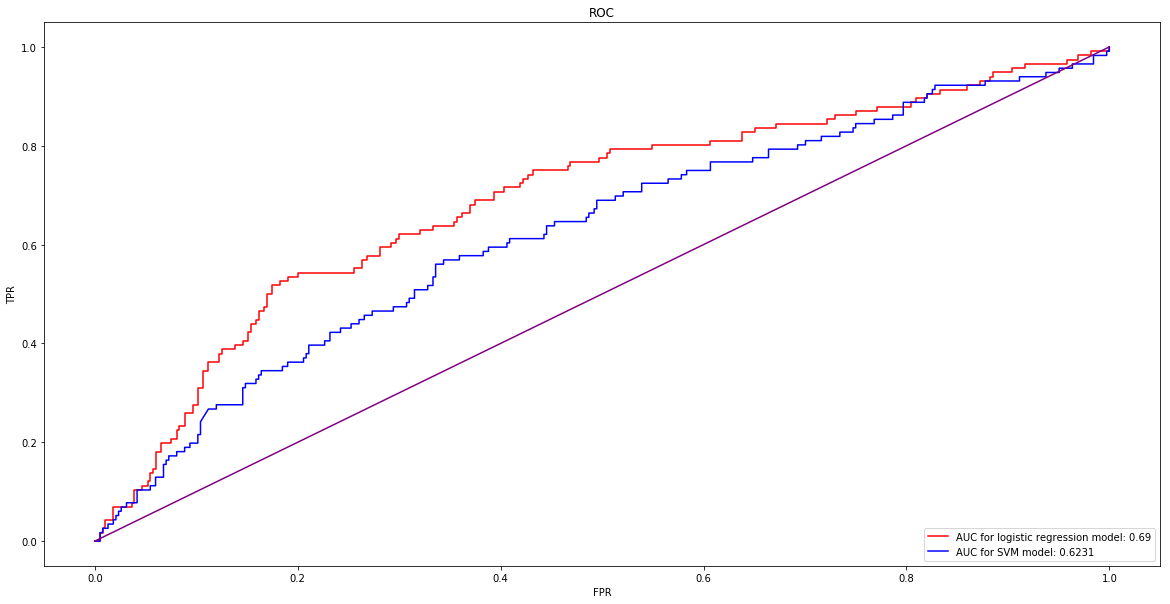

In [75]:
#calculates svm fpr, tpr, and auc values
fpr_svm, tpr_svm, thresholds_svm = metrics.roc_curve(y_test, y_score_svm)
roc_auc_svm = auc(fpr_svm, tpr_svm)

#graph
plt.figure(figsize=(20,10))

plt.plot(fpr_logistic, tpr_logistic, color = 'red', label= 'AUC for logistic regression model: ' + str(round(roc_auc_logistic, 4)))
plt.plot(fpr_svm, tpr_svm, color = 'blue', label = 'AUC for SVM model: ' + str(round(roc_auc_svm, 4)))
plt.plot(fpr_logistic, fpr_logistic, color='purple')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC')
plt.legend(loc="lower right")

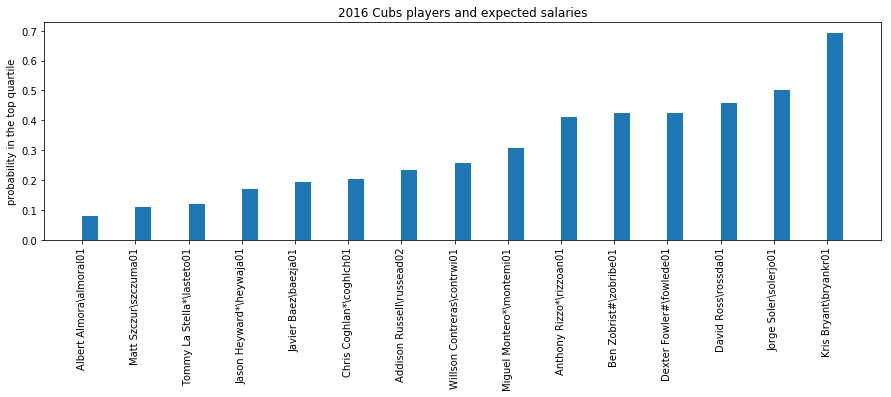

In [76]:
#The above is the graph for the ROC curves of the logistic and SVM model respectively.  the
#logistic model has a higher AUC

#reads in cubs dataframe
cubs = pd.read_csv('cubs_stats_2016.csv')
#restricts it to players with at least 70 at bats
cubs = cubs.loc[cubs['AB'] > 70]

#creates a list of cubs names for graphing purposes
cubs_names = np.asarray(cubs['Name'])

#renames differing columns
cubs.rename(columns={'GDP': 'GIDP'}, inplace=True)

#replaces numberic features with rate features
for stat in rates:
    cubs[stat] = cubs[stat]/cubs['PA']
    cubs.rename(columns={stat: stat + '/PA'}, inplace = True)

#drops accessive variables
cubs = cubs.drop(['Rk', 'Pos', 'Name', 'Age', 'G', 'PA', 'AB', 'SF', 'G', 'AB', 'BA', 'OBP', 'SLG', 'OPS', 'OPS+', 'TB', 'HBP', 'SH', 'SF'], axis=1)

#makes sure they have corresponding columns
columnsTitles= batters.columns[:-1]
cubs = cubs.reindex(columns=columnsTitles)

#preprocesses columns in cubs dataframe to match with batters dataframe
for column_name in cubs:
    cubs[column_name] = preprocessing.scale(cubs[column_name])

#predicts cubs salaries
cubs_scores = svm_model.predict_proba(cubs)[:,1]

cubs_sort = pd.DataFrame({'cubs_names': cubs_names, 'scores': cubs_scores})
cubs_sort = cubs_sort.sort_values(by='scores')

cubs_names = cubs_sort['cubs_names']
cubs_scores = cubs_sort['scores']


#graph
x_pos = np.arange(len(cubs_scores))

plt.figure(figsize=(15, 4)) 
    
plt.bar(x_pos, cubs_scores, align='edge', width=0.3)
plt.xticks(x_pos, cubs_names)
plt.ylabel('probability in the top quartile')
plt.title('2016 Cubs players and expected salaries')
plt.xticks(rotation=90)

plt.show()
